In [1]:
import sys, os
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import quad, nquad
from sklearn.preprocessing import normalize
from sktree.tree import DecisionTreeClassifier
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy

import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.stats import gamma
from simulations import *
from sklearn import metrics

In [2]:
from hyppo import make_trunk_classification

In [1]:
SIMULATIONS = {
    "1" : {},
    "2" : {"m_factor" : 1},
    "3" : {"band_type" : "ar", "rho" : 0.5},
    "4" : {"band_type" : "ar", "m_factor" : 1, "rho" : 0.5},
    "5" : {"mix" : 0.5}
}

### TRUNK

1
Dimension256
entropy0.018205466547358797
MI0.6749417140125865
pAUC 0.9987425157894736
[0.e+00 2.e-05 4.e-05 ... 1.e+00 1.e+00 1.e+00]
S@98 0.99808


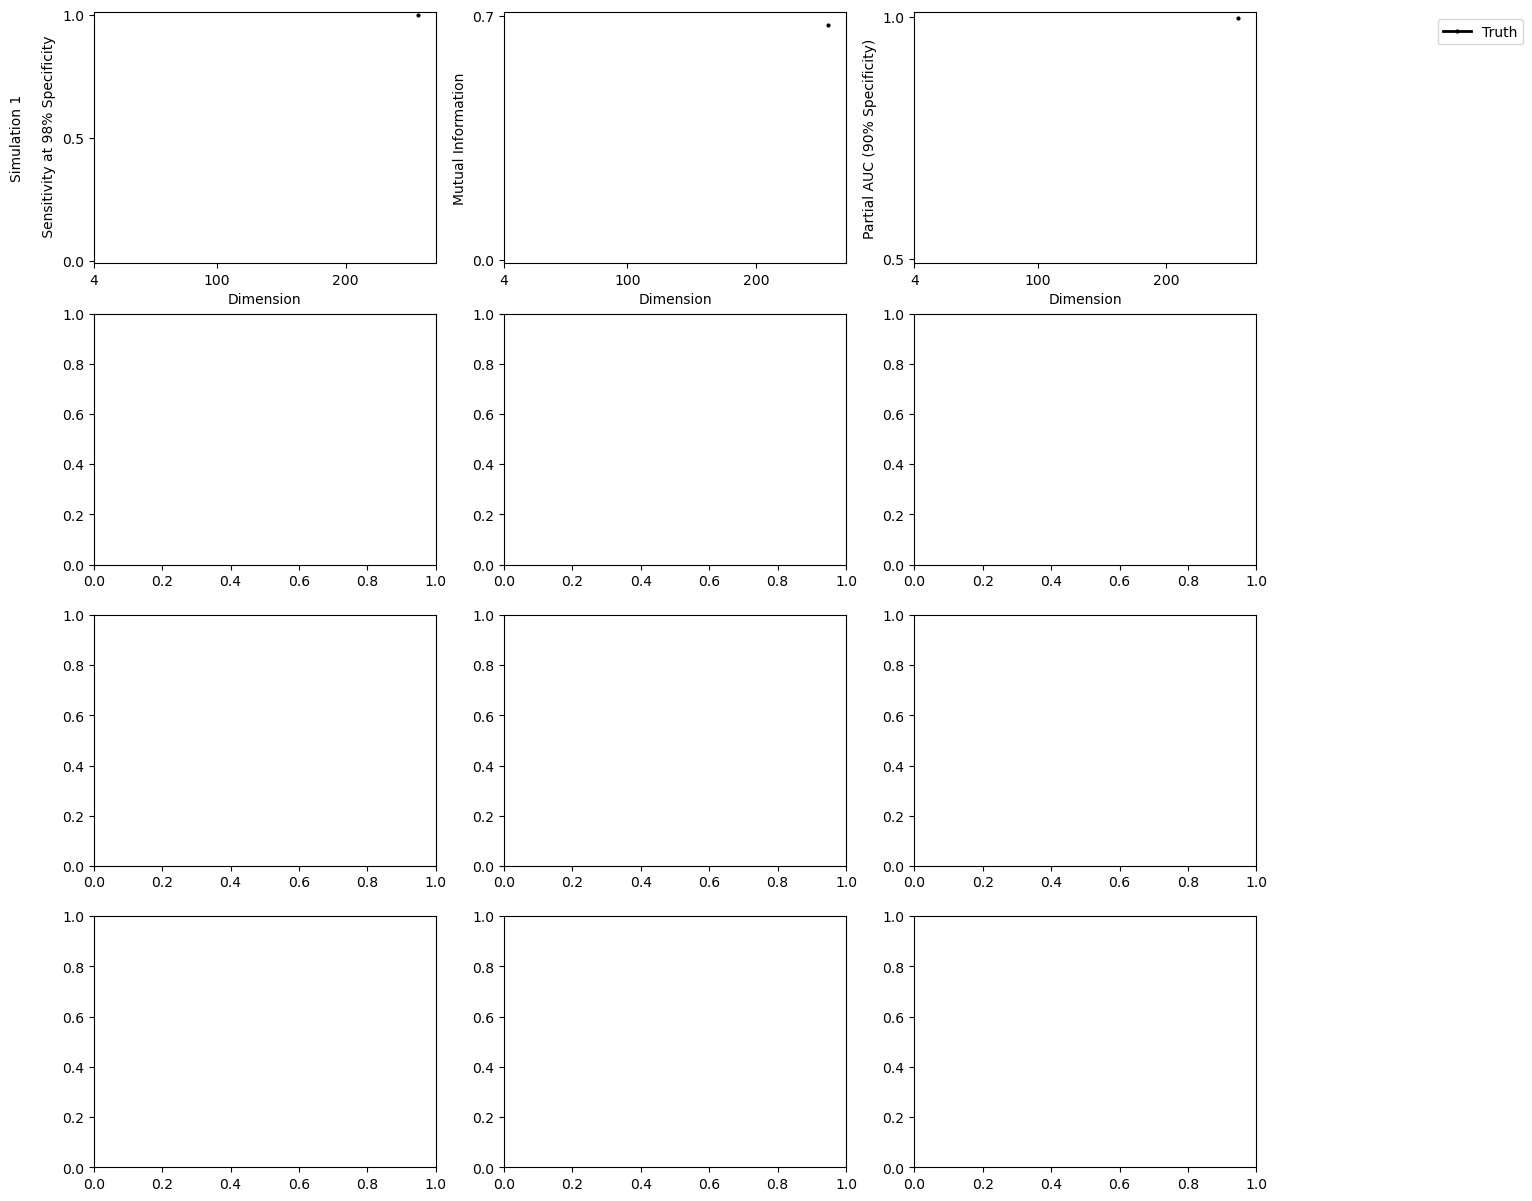

In [7]:
n = 100000

DIMENSIONS = [2**i for i in range(8, 9)]
# DIMENSIONS = [i for i in range(2, 100,2)]
plt.rcParams["font.size"] = 10
fig, axs = plt.subplots(4, 3,figsize=(15, 15))
for i in ["1"]:
    print(int(i))
    MIs = []
    pAUCs = []
    tprs = []
    for p in DIMENSIONS:
        print("Dimension" + str(p))
        ### sample from TRUNK
        x,y,mu,cov = make_trunk_classification(n_samples=n, n_dim=p, **SIMULATIONS[i],return_params = True)
        p_class0 = 0.5
        p_class1 = 0.5
        x = np.float32(x)
        y = np.float32(y)
        ## Get the pdf for class one and class two
        pdf_class0 = multivariate_normal(mean = mu[0], cov = cov[0],allow_singular=True)
        pdf_class1 = multivariate_normal(mean = mu[1], cov = cov[1],allow_singular=True)
        
        p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
        p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))


        p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
        # pos_class0 = p_x_given_class0*p_class0/p_x

        pos_class0 = (np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1))
        pos_class1 = np.ones(pos_class0.shape) - pos_class0

        posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
        # print(posterior.shape)
        # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
        stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
        prior_y = np.array([p_class0,p_class1])
        entropy_y = entropy(prior_y, base=np.exp(1))
        print('entropy'+str(stats_conen))
        MI = entropy_y - stats_conen
        print("MI"+str(MI))
        MIs.append(MI)
        # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
        # plt.show()
        pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
        print('pAUC '+ str(pauc))
        pAUCs.append(pauc)

        fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
        print(tpr)
        # plt.plot(fpr,tpr)
        if len(tpr) == len(fpr) == 2:
            tprs.append(0.02)
        elif len(tpr[np.round(fpr, 3)==0.02]) == 0:
            tpr_s = np.max(tpr[fpr<=0.02])
            print('S@98 '+ str(tpr_s))
            tprs.append(tpr_s)
        
        else:
            tpr_s = np.max(tpr[fpr<=0.02])
            print('S@98 '+ str(tpr_s))
            tprs.append(tpr_s)
    np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Trunk_{}.csv".format(i), tprs, delimiter=",")

    axs[int(i)-1,0].plot(DIMENSIONS,tprs,
                        'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
    axs[int(i)-1,0].set_ylabel('Simulation '+ str(i)+ '\n \n Sensitivity at 98% Specificity')
    axs[int(i)-1,0].set_xlabel('Dimension')
    axs[int(i)-1,0].set_ylim((-0.01,1.01))
    axs[int(i)-1,0].set_yticks((0,0.5,1))
    axs[int(i)-1,0].set_xticks((4,100,200))

    axs[int(i)-1,1].plot(DIMENSIONS,MIs,
                        'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
    axs[int(i)-1,1].set_ylabel('Mutual Information')
    axs[int(i)-1,1].set_xlabel('Dimension')
    axs[int(i)-1,1].set_ylim((-0.01,0.71))
    axs[int(i)-1,1].set_yticks((0,0.7))
    axs[int(i)-1,1].set_xticks((4,100,200))

    axs[int(i)-1,2].plot(DIMENSIONS,pAUCs,
                        'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
    axs[int(i)-1,2].set_ylabel('Partial AUC (90% Specificity)')
    axs[int(i)-1,2].set_xlabel('Dimension')
    axs[int(i)-1,2].set_ylim((0.49,1.01))
    axs[int(i)-1,2].set_yticks((0.5,1))
    axs[int(i)-1,2].set_xticks((4,100,200))

    axs[int(i)-1,2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')


In [23]:
#### Mixture Gaussian
n = 100000
MIs = []
pAUCs = []
tprs = []
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    mu_class1 = np.array([1/np.sqrt(i+1) for i in range(p)])
    sig = np.identity(p)
    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1, cov = sig,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = -mu_class1, cov = sig,allow_singular=True)

    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1)
    x_1_2 = pdf_class1_2.rvs(size = n2)
    x = np.vstack((x_0,x_1_1,x_1_2))
    y = np.array([0]*n+[1]*n).reshape(-1,1)

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x))
    p_x_given_class1 = 0.5*p_x_given_class1_1+0.5*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Mixture_Gaussian.csv", tprs, delimiter=",")




MI0.10043861936391474
pAUC 0.6231504947368421
S@98 0.19224
MI0.14266059928168273
pAUC 0.6599032405263158
S@98 0.25137
MI0.186135995049458
pAUC 0.6922189215789474
S@98 0.30747
MI0.22914032581595256
pAUC 0.7306741168421053
S@98 0.37319
MI0.2700314080514234
pAUC 0.761531107368421
S@98 0.44178
MI0.3082623374198656
pAUC 0.788302225263158
S@98 0.49677
MI0.34406402765006877
pAUC 0.8176725431578947
S@98 0.55933


Text(0.5, 0.98, 'Mixture Gaussian')

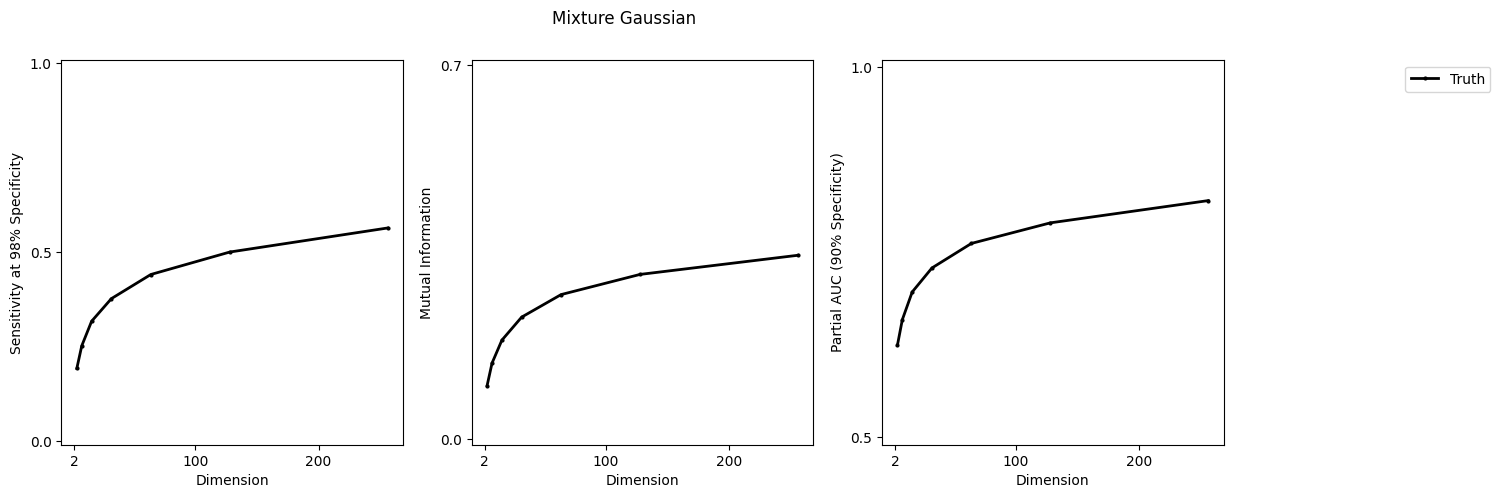

In [20]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,100,200))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,100,200))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,100,200))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

plt.suptitle('Mixture Gaussian')

## Skewed Unimodal

In [24]:
#### Skewed Unimodal
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)
    mu_class1_1 = np.array([0 for i in range(p)])
    mu_class1_2 = np.array([1/2 for i in range(p)])
    mu_class1_3 = np.array([12/13 for i in range(p)])
    sig_1_1 = np.identity(p)
    sig_1_2 = (4/9)*np.identity(p)
    sig_1_3 = (25/81)*np.identity(p)
    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1_1, cov = sig_1_1,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu_class1_2, cov =sig_1_2,allow_singular=True)
    pdf_class1_3 = multivariate_normal(mean = mu_class1_3, cov =sig_1_3,allow_singular=True)
    
    n1_1 = np.random.binomial(n, 0.2)
    n1_2 = np.random.binomial(n, 0.2)
    n1_3 = n - n1_1-n1_2
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1_1)
    x_1_2 = pdf_class1_2.rvs(size = n1_2)
    x_1_3 = pdf_class1_3.rvs(size = n1_3)
    z_2 = np.vstack((x_1_1,x_1_2,x_1_3))
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    
    mu_class1_1_weighted  = mu_class1_1*coeff_z2+mu_class0*coeff_z1
    mu_class1_2_weighted  = mu_class1_2*coeff_z2+mu_class0*coeff_z1
    mu_class1_3_weighted  = mu_class1_3*coeff_z2+mu_class0*coeff_z1
    sig_1_1_weighted  = sig_1_1*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_2_weighted  = sig_1_2*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_3_weighted  = sig_1_3*np.square(coeff_z2)+sig_0*np.square(coeff_z1)


    pdf_class1_1_weighted = multivariate_normal(mean = mu_class1_1_weighted, cov = sig_1_1_weighted,allow_singular=True)
    pdf_class1_2_weighted = multivariate_normal(mean = mu_class1_2_weighted, cov =sig_1_2_weighted,allow_singular=True)
    pdf_class1_3_weighted = multivariate_normal(mean = mu_class1_3_weighted, cov =sig_1_3_weighted,allow_singular=True)
    
    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1_weighted.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2_weighted.pdf(x))
    p_x_given_class1_3 = np.nan_to_num(pdf_class1_3_weighted.pdf(x))

    p_x_given_class1 = 0.2*p_x_given_class1_1+0.2*p_x_given_class1_2+0.6*p_x_given_class1_3

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Skewed_Unimodal.csv", tprs, delimiter=",")




MI0.2370302300727838
pAUC 0.6970173536842106
S@98 0.27194
MI0.3241472997667929
pAUC 0.780820062631579
S@98 0.45876
MI0.3998355536940342
pAUC 0.8418148610526316
S@98 0.60874
MI0.46099262149445674
pAUC 0.8892458894736842
S@98 0.71813
MI0.5078103181980063
pAUC 0.92251629
S@98 0.80243
MI0.5461465742928849
pAUC 0.9473388473684211
S@98 0.86445
MI0.5739532184063624
pAUC 0.9640251294736841
S@98 0.90422


Text(0.5, 0.98, 'Mixture Gaussian')

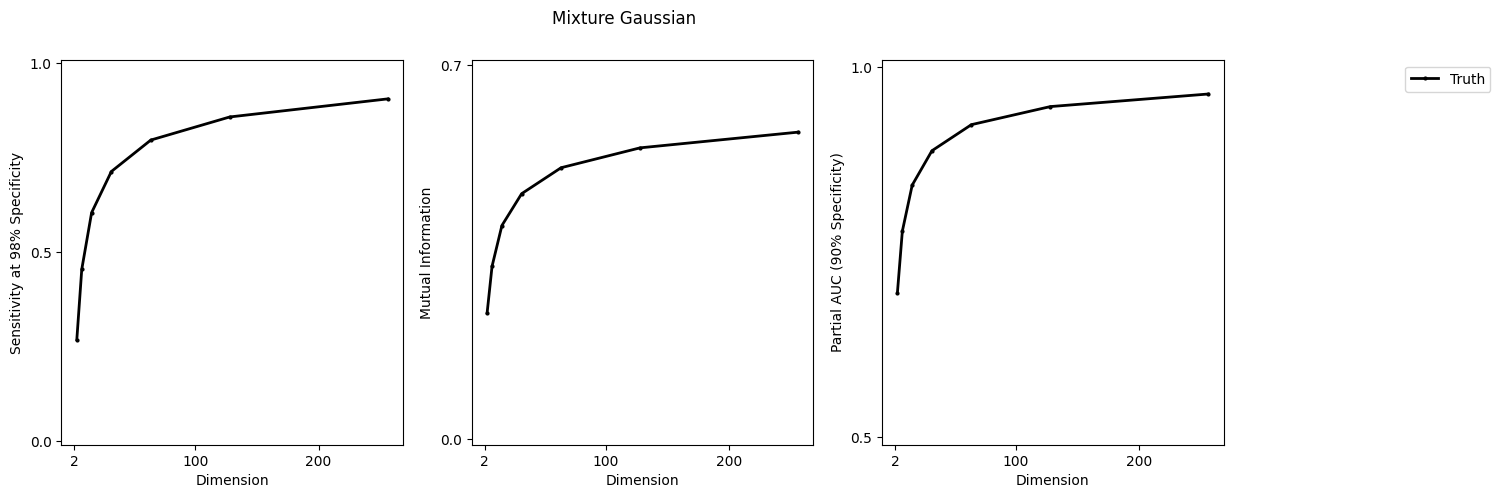

In [6]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,100,200))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,100,200))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,100,200))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

plt.suptitle('Skewed Unimodal')

## Strongly Skewed

## Kurtotic Unimodal

In [25]:
### Kurtotic Unimodal
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)
    mu_class1_1 = np.array([0 for i in range(p)])
    mu_class1_2 = np.array([0 for i in range(p)])
    
    sig_1_1 = np.identity(p)
    sig_1_2 = (1/100)*np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1_1, cov = sig_1_1,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu_class1_2, cov =sig_1_2,allow_singular=True)
    
    n1_1 = np.random.binomial(n, 2/3)
    # print(n1_1)
    n1_2 = n - n1_1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1_1)
    x_1_2 = pdf_class1_2.rvs(size = n1_2)
    z_2 = np.vstack((x_1_1,x_1_2))
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    
    mu_class1_1_weighted  = mu_class1_1*coeff_z2+mu_class0*coeff_z1
    mu_class1_2_weighted  = mu_class1_2*coeff_z2+mu_class0*coeff_z1

    sig_1_1_weighted  = sig_1_1*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_2_weighted  = sig_1_2*np.square(coeff_z2)+sig_0*np.square(coeff_z1)



    pdf_class1_1_weighted = multivariate_normal(mean = mu_class1_1_weighted, cov = sig_1_1_weighted,allow_singular=True)
    pdf_class1_2_weighted = multivariate_normal(mean = mu_class1_2_weighted, cov =sig_1_2_weighted,allow_singular=True)
    
    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1_weighted.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2_weighted.pdf(x))


    p_x_given_class1 = (2/3)*p_x_given_class1_1+(1/3)*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Kurtotic_Unimodal.csv", tprs, delimiter=",")



MI0.14888712701406215
pAUC 0.6586952505263157
S@98 0.28645
MI0.22469933369581974
pAUC 0.7008524226315789
S@98 0.34955
MI0.3046265243140798
pAUC 0.7541760463157895
S@98 0.4234
MI0.37595968473183716
pAUC 0.8129794721052631
S@98 0.53531
MI0.4345032853709957
pAUC 0.8606846468421052
S@98 0.64008
MI0.48369959808085405
pAUC 0.899846807368421
S@98 0.73544
MI0.5219711624859653
pAUC 0.9293670447368421
S@98 0.812


Text(0.5, 0.98, 'Kurtotic Unimodal')

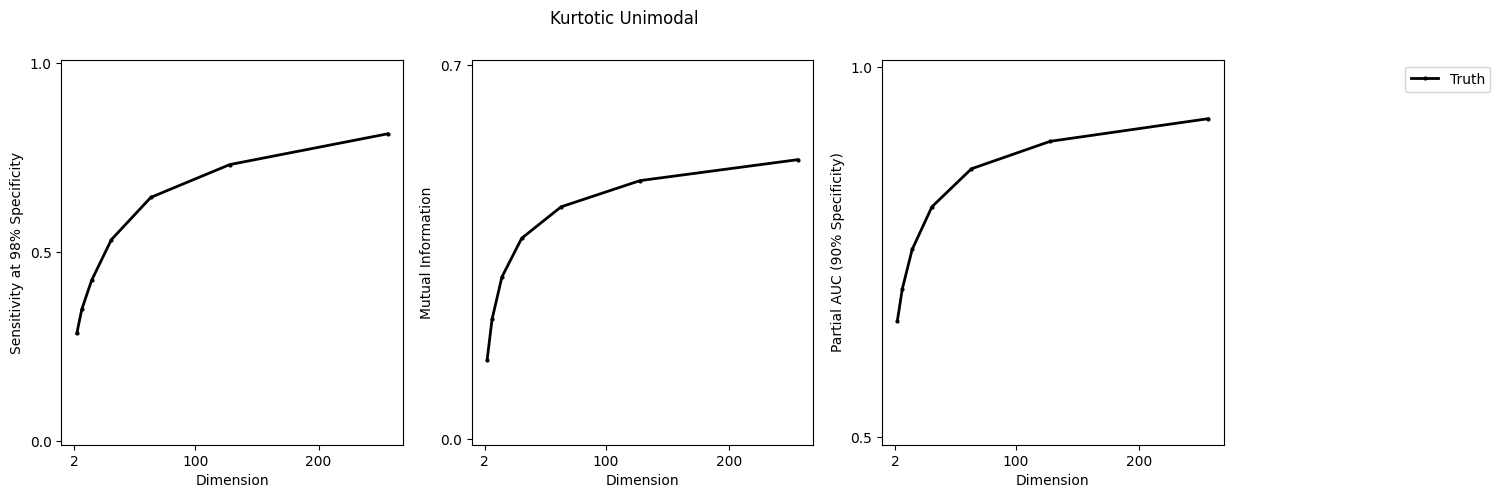

In [10]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,100,200))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,100,200))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,100,200))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

plt.suptitle('Kurtotic Unimodal')

## Outlier

In [26]:
### Outlier
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)
    mu_class1_1 = np.array([0 for i in range(p)])
    mu_class1_2 = np.array([0 for i in range(p)])
    
    sig_1_1 = np.identity(p)
    sig_1_2 = (1/100)*np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1_1, cov = sig_1_1,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu_class1_2, cov =sig_1_2,allow_singular=True)
    
    n1_1 = np.random.binomial(n, 1/10)
    # print(n1_1)
    n1_2 = n - n1_1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1_1)
    x_1_2 = pdf_class1_2.rvs(size = n1_2)
    z_2 = np.vstack((x_1_1,x_1_2))
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    
    mu_class1_1_weighted  = mu_class1_1*coeff_z2+mu_class0*coeff_z1
    mu_class1_2_weighted  = mu_class1_2*coeff_z2+mu_class0*coeff_z1

    sig_1_1_weighted  = sig_1_1*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_2_weighted  = sig_1_2*np.square(coeff_z2)+sig_0*np.square(coeff_z1)



    pdf_class1_1_weighted = multivariate_normal(mean = mu_class1_1_weighted, cov = sig_1_1_weighted,allow_singular=True)
    pdf_class1_2_weighted = multivariate_normal(mean = mu_class1_2_weighted, cov =sig_1_2_weighted,allow_singular=True)
    
    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1_weighted.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2_weighted.pdf(x))


    p_x_given_class1 = (1/10)*p_x_given_class1_1+(9/10)*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Outlier.csv", tprs, delimiter=",")





MI0.44092182015069853
pAUC 0.8855386189473684
S@98 0.69941
MI0.4847862364046617
pAUC 0.9201224184210526
S@98 0.82451
MI0.5203473896942746
pAUC 0.9402474621052632
S@98 0.87008
MI0.5512351418120499
pAUC 0.9549659810526315
S@98 0.8956
MI0.5773686045279468
pAUC 0.9672830905263157
S@98 0.92307
MI0.5980512710899101
pAUC 0.9770488852631579
S@98 0.94417
MI0.6152972839222376
pAUC 0.9834058242105261
S@98 0.96053


Text(0.5, 0.98, 'Outlier')

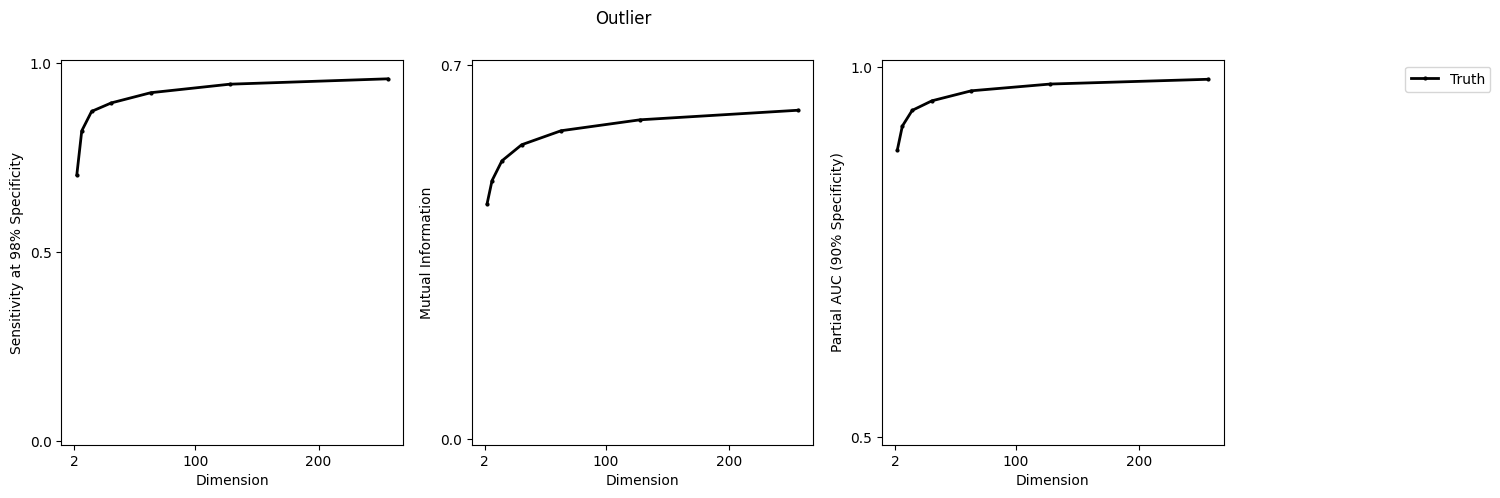

In [12]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,100,200))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,100,200))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,100,200))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

plt.suptitle('Outlier')

### Bimodal

In [27]:
### Bimodal
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)
    mu_class1_1 = np.array([-1 for i in range(p)])
    mu_class1_2 = np.array([1 for i in range(p)])
    
    sig_1_1 = (4/9)*np.identity(p)
    sig_1_2 = (4/9)*np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1_1, cov = sig_1_1,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu_class1_2, cov =sig_1_2,allow_singular=True)
    
    p = 1/2
    n1_1 = np.random.binomial(n, p)
    # print(n1_1)
    n1_2 = n - n1_1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1_1)
    x_1_2 = pdf_class1_2.rvs(size = n1_2)
    z_2 = np.vstack((x_1_1,x_1_2))
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    
    mu_class1_1_weighted  = mu_class1_1*coeff_z2+mu_class0*coeff_z1
    mu_class1_2_weighted  = mu_class1_2*coeff_z2+mu_class0*coeff_z1

    sig_1_1_weighted  = sig_1_1*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_2_weighted  = sig_1_2*np.square(coeff_z2)+sig_0*np.square(coeff_z1)



    pdf_class1_1_weighted = multivariate_normal(mean = mu_class1_1_weighted, cov = sig_1_1_weighted,allow_singular=True)
    pdf_class1_2_weighted = multivariate_normal(mean = mu_class1_2_weighted, cov =sig_1_2_weighted,allow_singular=True)
    
    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1_weighted.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2_weighted.pdf(x))


    p_x_given_class1 = p*p_x_given_class1_1+(1-p)*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Bimodal.csv", tprs, delimiter=",")



MI0.2610885637707866
pAUC 0.67935941
S@98 0.2328
MI0.38482262111068605
pAUC 0.7937391210526317
S@98 0.45828
MI0.4745362418146924
pAUC 0.8814157484210526
S@98 0.67849
MI0.5380037947219697
pAUC 0.9316331889473684
S@98 0.81512
MI0.5807553934862785
pAUC 0.9620659442105264
S@98 0.90289
MI0.6114296913261951
pAUC 0.9797050652631578
S@98 0.95279
MI0.6337291158473524
pAUC 0.9884816626315789
S@98 0.97513


Text(0.5, 0.98, 'Bimodal')

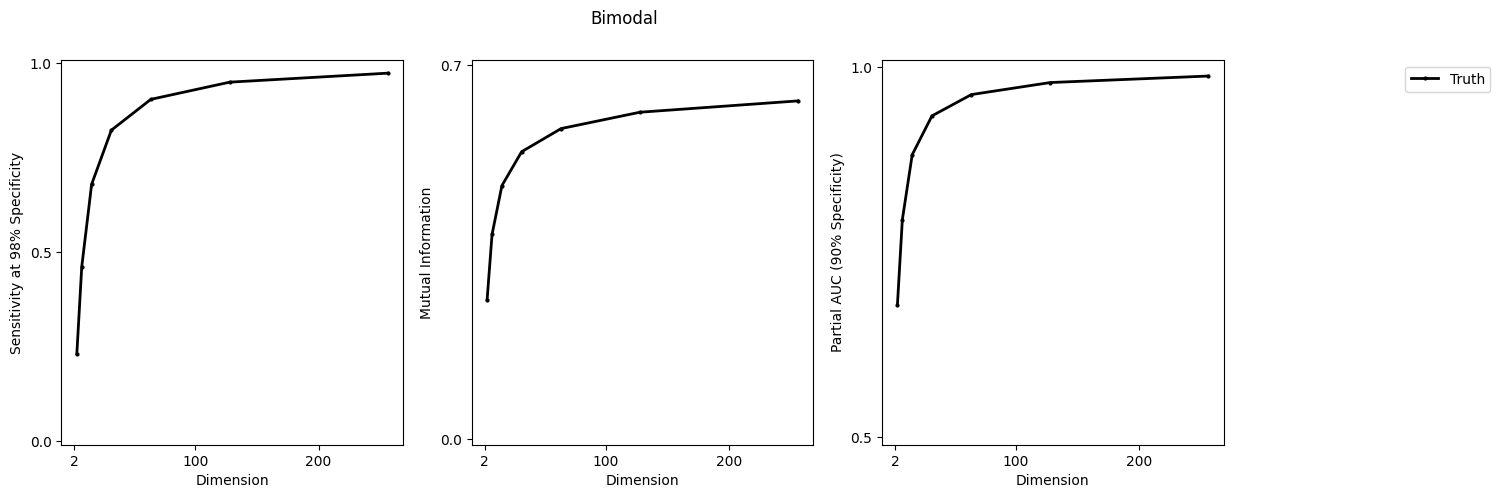

In [14]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,100,200))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,100,200))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,100,200))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

plt.suptitle('Bimodal')

## Separated Bimodal

In [28]:
### Bimodal
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)
    mu_class1_1 = np.array([-3/2 for i in range(p)])
    mu_class1_2 = np.array([3/2 for i in range(p)])
    
    sig_1_1 = (1/4)*np.identity(p)
    sig_1_2 = (1/4)*np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1_1, cov = sig_1_1,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu_class1_2, cov =sig_1_2,allow_singular=True)
    
    p = 1/2
    n1_1 = np.random.binomial(n, p)
    # print(n1_1)
    n1_2 = n - n1_1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1_1)
    x_1_2 = pdf_class1_2.rvs(size = n1_2)
    z_2 = np.vstack((x_1_1,x_1_2))
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    
    mu_class1_1_weighted  = mu_class1_1*coeff_z2+mu_class0*coeff_z1
    mu_class1_2_weighted  = mu_class1_2*coeff_z2+mu_class0*coeff_z1

    sig_1_1_weighted  = sig_1_1*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_2_weighted  = sig_1_2*np.square(coeff_z2)+sig_0*np.square(coeff_z1)



    pdf_class1_1_weighted = multivariate_normal(mean = mu_class1_1_weighted, cov = sig_1_1_weighted,allow_singular=True)
    pdf_class1_2_weighted = multivariate_normal(mean = mu_class1_2_weighted, cov =sig_1_2_weighted,allow_singular=True)
    
    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1_weighted.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2_weighted.pdf(x))


    p_x_given_class1 = p*p_x_given_class1_1+(1-p)*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Separated_Bimodal.csv", tprs, delimiter=",")




MI0.5080176225583501
pAUC 0.8892351731578947
S@98 0.67624
MI0.5864794933233697
pAUC 0.9593202831578947
S@98 0.89622
MI0.6294483713143608
pAUC 0.9844980931578947
S@98 0.97016
MI0.654437236801647
pAUC 0.9945920894736842
S@98 0.99221
MI0.6686819355748189
pAUC 0.9977318289473684
S@98 0.99773
MI0.6773848981286941
pAUC 0.9989742778947368
S@98 0.99924
MI0.6830957745449959
pAUC 0.9995409394736843
S@98 0.99982


Text(0.5, 0.98, 'Separate Bimodal')

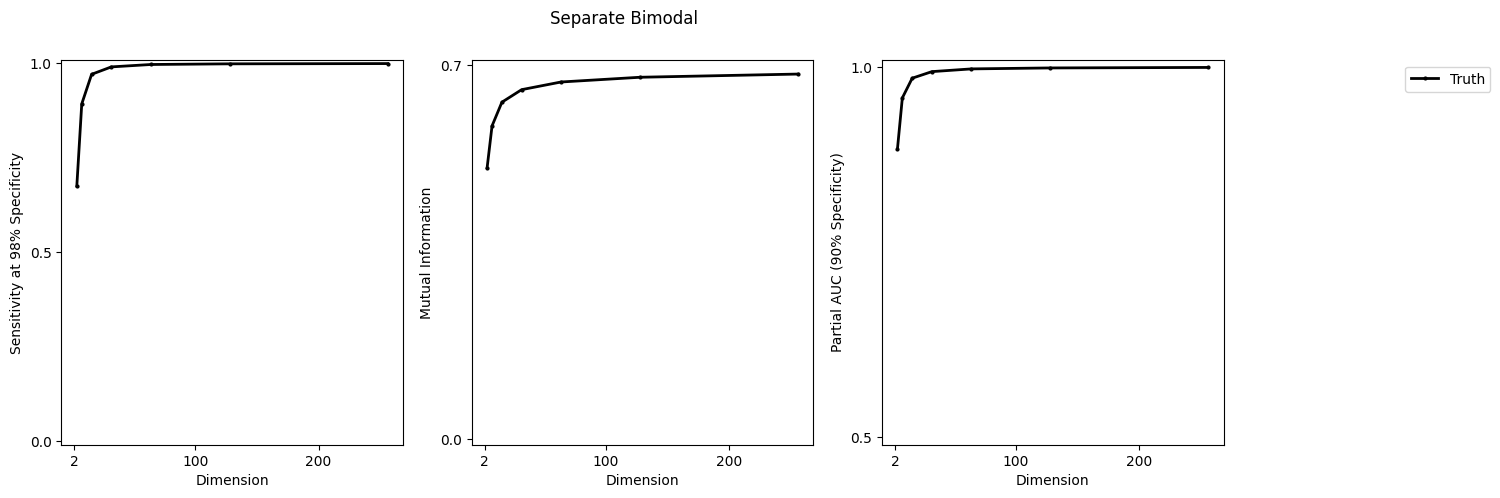

In [16]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,100,200))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,100,200))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,100,200))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

plt.suptitle('Separate Bimodal')

Skewed Bimodal

In [40]:
### Skewed Bimodal
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5
for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)
    mu_class1_1 = np.array([0 for i in range(p)])
    mu_class1_2 = np.array([3/2 for i in range(p)])
    
    sig_1_1 = np.identity(p)
    sig_1_2 = np.square(1/3)*np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1_1, cov = sig_1_1,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu_class1_2, cov =sig_1_2,allow_singular=True)
    
    p = 3/4
    n1_1 = np.random.binomial(n, p)
    # print(n1_1)
    n1_2 = n - n1_1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1_1)
    x_1_2 = pdf_class1_2.rvs(size = n1_2)
    z_2 = np.vstack((x_1_1,x_1_2))
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    
    mu_class1_1_weighted  = mu_class1_1*coeff_z2+mu_class0*coeff_z1
    mu_class1_2_weighted  = mu_class1_2*coeff_z2+mu_class0*coeff_z1

    sig_1_1_weighted  = sig_1_1*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
    sig_1_2_weighted  = sig_1_2*np.square(coeff_z2)+sig_0*np.square(coeff_z1)



    pdf_class1_1_weighted = multivariate_normal(mean = mu_class1_1_weighted, cov = sig_1_1_weighted,allow_singular=True)
    pdf_class1_2_weighted = multivariate_normal(mean = mu_class1_2_weighted, cov =sig_1_2_weighted,allow_singular=True)
    
    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1_weighted.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2_weighted.pdf(x))


    p_x_given_class1 = p*p_x_given_class1_1+(1-p)*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Skewed_Bimodal.csv", tprs, delimiter=",")




MI0.1265832839347698
pAUC 0.6293415105263158
S@98 0.24813
MI0.20676300916602436
pAUC 0.6779637384210526
S@98 0.30191
MI0.2908017261711566
pAUC 0.7413222168421052
S@98 0.39578
MI0.36465172917408833
pAUC 0.8031772221052631
S@98 0.51402
MI0.42609894634802065
pAUC 0.8525838168421052
S@98 0.61837
MI0.4773722087434241
pAUC 0.8959142415789474
S@98 0.72512
MI0.5173812437721691
pAUC 0.9242926868421052
S@98 0.8


## Trimodal

In [41]:
## Trimodal

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([9/20 if k <= 1 else 1/10 for k in range(3)])
    print(sum(prior_p))
    for i in range(3):
        if i==0:
            mu_class1_i = np.array([-6/5 for _ in range(p)])
            sig_1_i = np.square(3/5)*np.identity(p)
        elif i==1:
            mu_class1_i = np.array([6/5 for _ in range(p)])
            sig_1_i = np.square(3/5)*np.identity(p)
        else:
            mu_class1_i = np.array([0 for _ in range(p)])
            sig_1_i = np.square(1/4)*np.identity(p)
        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <2:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(3):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)

np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Trimodal.csv", tprs, delimiter=",")



1.0
MI0.2885248797252763
pAUC 0.7134464068421053
S@98 0.3037
1.0
MI0.3948840415616861
pAUC 0.8316854805263159
S@98 0.55194
1.0
MI0.4828046542222914
pAUC 0.9099149363157895
S@98 0.7483
1.0
MI0.5439290997837068
pAUC 0.9511351805263158
S@98 0.86924
1.0
MI0.5870911559052401
pAUC 0.9737534142105262
S@98 0.93285
1.0
MI0.6162942642629795
pAUC 0.9857972031578945
S@98 0.96587
1.0
MI0.636870371828872
pAUC 0.9917256689473684
S@98 0.98244


### Strongly Skewed

In [29]:
### Strongly Skewed
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([1/8 for p in range(8)])
    for i in range(8):
        mu_class1_i = np.array([3*(2/3)**i-1 for _ in range(p)])
        mu_class1.append(mu_class1_i)
        sig_1_i = (2/3)**(2*i)*np.identity(p)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <7:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(8):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Strongly_Skewed.csv", tprs, delimiter=",")




MI0.3552425515479054
pAUC 0.7603989226315789
S@98 0.41628
MI0.4474280197779684
pAUC 0.8500283794736843
S@98 0.60059
MI0.5139940571893992
pAUC 0.9111997384210526
S@98 0.75236
MI0.5582254118974681
pAUC 0.9461372078947368
S@98 0.85106
MI0.5903941627798487
pAUC 0.9679167757894737
S@98 0.91588
MI0.6133499709760484
pAUC 0.9802383147368421
S@98 0.95009
MI0.6311661789690123
pAUC 0.9871721842105263
S@98 0.97059


## Claw

In [30]:
## Claw

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([1/2 if k == 0 else 1/10 for k in range(5)])
    for i in range(5):
        if i==0:
            mu_class1_i = np.array([0 for _ in range(p)])
            sig_1_i = np.identity(p)
        else:
            mu_class1_i = np.array([((i-1)/2)-1 for _ in range(p)])
            sig_1_i = (1/100)*np.identity(p)
        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <4:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(5):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)

np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Claw.csv", tprs, delimiter=",")



MI0.3152242656880713
pAUC 0.6728769431578947
S@98 0.26358
MI0.36901706469134177
pAUC 0.7303908005263158
S@98 0.39978
MI0.4106605282582527
pAUC 0.7851657889473684
S@98 0.49545
MI0.4487446484212332
pAUC 0.8373758010526315
S@98 0.59359
MI0.48416886805991804
pAUC 0.8793242626315789
S@98 0.68669
MI0.5172639648319874
pAUC 0.9154542968421053
S@98 0.7752
MI0.5450968149012112
pAUC 0.9390211231578947
S@98 0.8388


## Double Claw

In [31]:
## Double Claw

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([49/100 if k <= 1 else 1/350 for k in range(9)])
    print(sum(prior_p))
    for i in range(9):
        if i == 0:
            mu_class1_i = np.array([-1 for _ in range(p)])
            sig_1_i = np.identity(p)
        elif i == 1:
            mu_class1_i = np.array([1 for _ in range(p)])
            sig_1_i = np.identity(p)
        else:
            mu_class1_i = np.array([(i-5)/2 for _ in range(p)])
            sig_1_i = (1/100)*np.identity(p)
        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <8:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(9):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)

np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Double_Claw.csv", tprs, delimiter=",")




1.0000000000000002
MI0.5708892558926152
pAUC 0.5683835736842106
S@98 0.08947
1.0000000000000002
MI0.5509996250566777
pAUC 0.6539862968421053
S@98 0.19685
1.0000000000000002
MI0.5212758821966929
pAUC 0.7551510115789474
S@98 0.3759
1.0000000000000002
MI0.5006338272883493
pAUC 0.8417263547368421
S@98 0.58225
1.0000000000000002
MI0.4960244043582769
pAUC 0.9013807168421053
S@98 0.7347
1.0000000000000002
MI0.508698711813077
pAUC 0.9376727526315789
S@98 0.83456
1.0000000000000002
MI0.5297943471715688
pAUC 0.9641879168421053
S@98 0.9059


## Asymmetric Claw

In [32]:
## Asymmetric Claw

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([1/2 if k == 0 else 2**(4-k)/31 for k in range(5)])
    for i in range(5):
        if i==0:
            mu_class1_i = np.array([0 for _ in range(p)])
            sig_1_i = np.identity(p)
        else:
            mu_class1_i = np.array([i-5/2 for _ in range(p)])
            sig_1_i = np.square(2**(3-i)/10)*np.identity(p)
        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <4:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(5):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Asymmetric_Claw.csv", tprs, delimiter=",")





MI0.39716615064877503
pAUC 0.6798530994736842
S@98 0.28689
MI0.44142338455073826
pAUC 0.7391842184210526
S@98 0.42518
MI0.47159580787924044
pAUC 0.7936764010526316
S@98 0.5158
MI0.4912799378433852
pAUC 0.8461726015789475
S@98 0.61266
MI0.509546284839362
pAUC 0.8873908363157894
S@98 0.70646
MI0.5293529366853866
pAUC 0.9184799042105263
S@98 0.78369
MI0.548908532193414
pAUC 0.9435630205263157
S@98 0.85034


## Asymmetric Double Claw

In [33]:
## Double Claw

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([46/100 if k <= 1 
                        else 1/300 if 1< k <=4
                        else 7/300 for k in range(8)])
    print(sum(prior_p))
    for i in range(8):
        if i <= 1:
            mu_class1_i = np.array([2*i-1 for _ in range(p)])
            sig_1_i = np.identity(p)
        elif 2<= i <= 4:
            mu_class1_i = np.array([-(i-1)/2 for _ in range(p)])
            sig_1_i = np.square(1/100)*np.identity(p)
        else:
            mu_class1_i = np.array([(i-4)/2 for _ in range(p)])
            sig_1_i = np.square(7/100)*np.identity(p)
        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <7:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(8):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)

np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Asymmetric_Double_Claw.csv", tprs, delimiter=",")



0.9999999999999999
MI0.4297192583834661
pAUC 0.6122746778947369
S@98 0.1321
0.9999999999999999
MI0.42673826738857706
pAUC 0.6994459026315789
S@98 0.27421
0.9999999999999999
MI0.43301098800006554
pAUC 0.7898771968421052
S@98 0.46118
0.9999999999999999
MI0.4582868794009243
pAUC 0.8657037089473685
S@98 0.64098
0.9999999999999999
MI0.49526876820856347
pAUC 0.9178848826315789
S@98 0.77846
0.9999999999999999
MI0.532426683635904
pAUC 0.9503728247368421
S@98 0.87028
0.9999999999999999
MI0.5646132114728338
pAUC 0.9703146199999999
S@98 0.92688


## Smooth Comb

In [34]:
## Smooth Comb

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([2**(5-k)/63 for k in range(6)])
    print(sum(prior_p))
    for i in range(6):
        mu_class1_i = np.array([(65-95*(1/2)**i)/21 for _ in range(p)])
        sig_1_i = np.square(32/63)/(2**(2*i))*np.identity(p)
        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <5:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(6):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)

np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Smooth_Comb.csv", tprs, delimiter=",")



1.0
MI0.4461851836370763
pAUC 0.877667884736842
S@98 0.64595
1.0
MI0.48303607425194006
pAUC 0.9472023978947368
S@98 0.85246
1.0
MI0.5378547649386578
pAUC 0.9770120684210526
S@98 0.94413
1.0
MI0.582907982330443
pAUC 0.9892277789473685
S@98 0.97738
1.0
MI0.6139761949854046
pAUC 0.9944940305263157
S@98 0.99066
1.0
MI0.6376081390845953
pAUC 0.9970829568421052
S@98 0.99618
1.0
MI0.6527329286294696
pAUC 0.9985680952631577
S@98 0.99833


## Discrete Comb

In [35]:
##  Discrete Comb

n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
p_class0 = 0.5
p_class1 = 0.5

for p in DIMENSIONS:
    mu_class0 = np.array([0 for i in range(p)])
    
    
    coeff_z2 = np.array([1/np.sqrt(i+1) for i in range(p)])
    coeff_z1 = np.array([1 -i for i in coeff_z2])
    
    sig_0 = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig_0,allow_singular=True)


    mu_class1 = []
    sig_1 = []
    pdf_class1 = []
    prior = []
    z_2 = np.zeros((n,p))
    n_1_total = 0
    prior_p = np.array([2/7 if k <=2 else 1/21 for k in range(6)])
    print(sum(prior_p))
    for i in range(6):
        if i <= 5:
            mu_class1_i = np.array([(12*i-15)/7 for _ in range(p)])
            sig_1_i = np.square(2/7)*np.identity(p)
        else:
            mu_class1_i = np.array([(2*(i+5))/7 for _ in range(p)])
            sig_1_i = np.square(1/21)*np.identity(p)

        mu_class1.append(mu_class1_i)
        sig_1.append(sig_1_i)
        pdf_class1_i = multivariate_normal(mean = mu_class1_i, cov = sig_1_i,allow_singular=True)
        pdf_class1.append(pdf_class1_i)
        if i <5:
            n_1_i = np.random.binomial(n, prior_p[i])
            prior.append(n_1_i)
        else:
            n_1_i = n-np.sum(prior)
            prior.append(n_1_i)
        z_2[n_1_total:n_1_total+n_1_i,:] = pdf_class1_i.rvs(size = n_1_i)
        n_1_total += n_1_i
    
    x_0 = pdf_class0.rvs(size = n)
    z_1 = pdf_class0.rvs(size = n)
    x_1 = coeff_z1*z_1 + coeff_z2*z_2

    x = np.vstack((x_0,x_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)
    

    mu_1_weighted = []
    sig_1_weighted = []
    pdf_class1_weighted = []
    p_x_given_class1 = 0
    
    for j in range(6):
        mu_class1_i = mu_class1[j]
        sig_1_i = sig_1[j]
        mu_class1_i_weighted = mu_class1_i*coeff_z2+mu_class0*coeff_z1
        mu_1_weighted.append(mu_class1_i_weighted)
        sig_1_i_weighted = sig_1_i*np.square(coeff_z2)+sig_0*np.square(coeff_z1)
        sig_1_weighted.append(sig_1_i_weighted)
        pdf_class1_i_weighted = multivariate_normal(mean = mu_class1_i_weighted, cov = sig_1_i_weighted,allow_singular=True)
        p_x_given_class1_i = np.nan_to_num(pdf_class1_i_weighted.pdf(x))
        p_x_given_class1 += prior_p[i]*p_x_given_class1_i

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Discrete_Comb.csv", tprs, delimiter=",")




1.0
MI0.46636615353375344
pAUC 0.8893669810526316
S@98 0.69289
1.0
MI0.5270734143552166
pAUC 0.9438249584210525
S@98 0.83831
1.0
MI0.5716067638401479
pAUC 0.9707331284210527
S@98 0.91979
1.0
MI0.6025990803772739
pAUC 0.9840529168421053
S@98 0.95921
1.0
MI0.6247953062697285
pAUC 0.9909247921052631
S@98 0.97913
1.0
MI0.6405024896037855
pAUC 0.9947244021052631
S@98 0.98909
1.0
MI0.6520015309556348
pAUC 0.9967479221052631
S@98 0.99421


In [43]:
SIMULATIONS = {
    "Trunk_1": "Trunk",
    "Trunk_2": "Trunk-Overlap",
    "Trunk_3": "Trunk-Banded",
    "Mixture_Gaussian": "Mixture Gaussian",
    "Skewed_Unimodal": "Skewed_Unimodal",
    "Strongly_Skewed": "Strongly Skewed",
    "Kurtotic_Unimodal": "Kurtotic Unimodal",
    "Outlier": "Outlier",
    "Bimodal": "Bimodal",
    "Separated_Bimodal": "Separated Bimodal",
    "Skewed_Bimodal": "Skewed Bimodal",
    "Trimodal": "Trimodal",
    "Claw": "Claw",
    "Double_Claw": "Double Claw",
    "Asymmetric_Claw": "Asymmetric Claw",
    "Asymmetric_Double_Claw": "Asymmetric Double Claw",
    "Smooth_Comb": "Smooth Comb",
    "Discrete_Comb": "Discrete Comb",
}
sim_name = list(SIMULATIONS.keys())
sim_name

['Trunk_1',
 'Trunk_2',
 'Trunk_3',
 'Mixture_Gaussian',
 'Skewed_Unimodal',
 'Strongly_Skewed',
 'Kurtotic_Unimodal',
 'Outlier',
 'Bimodal',
 'Separated_Bimodal',
 'Skewed_Bimodal',
 'Trimodal',
 'Claw',
 'Double_Claw',
 'Asymmetric_Claw',
 'Asymmetric_Double_Claw',
 'Smooth_Comb',
 'Discrete_Comb']

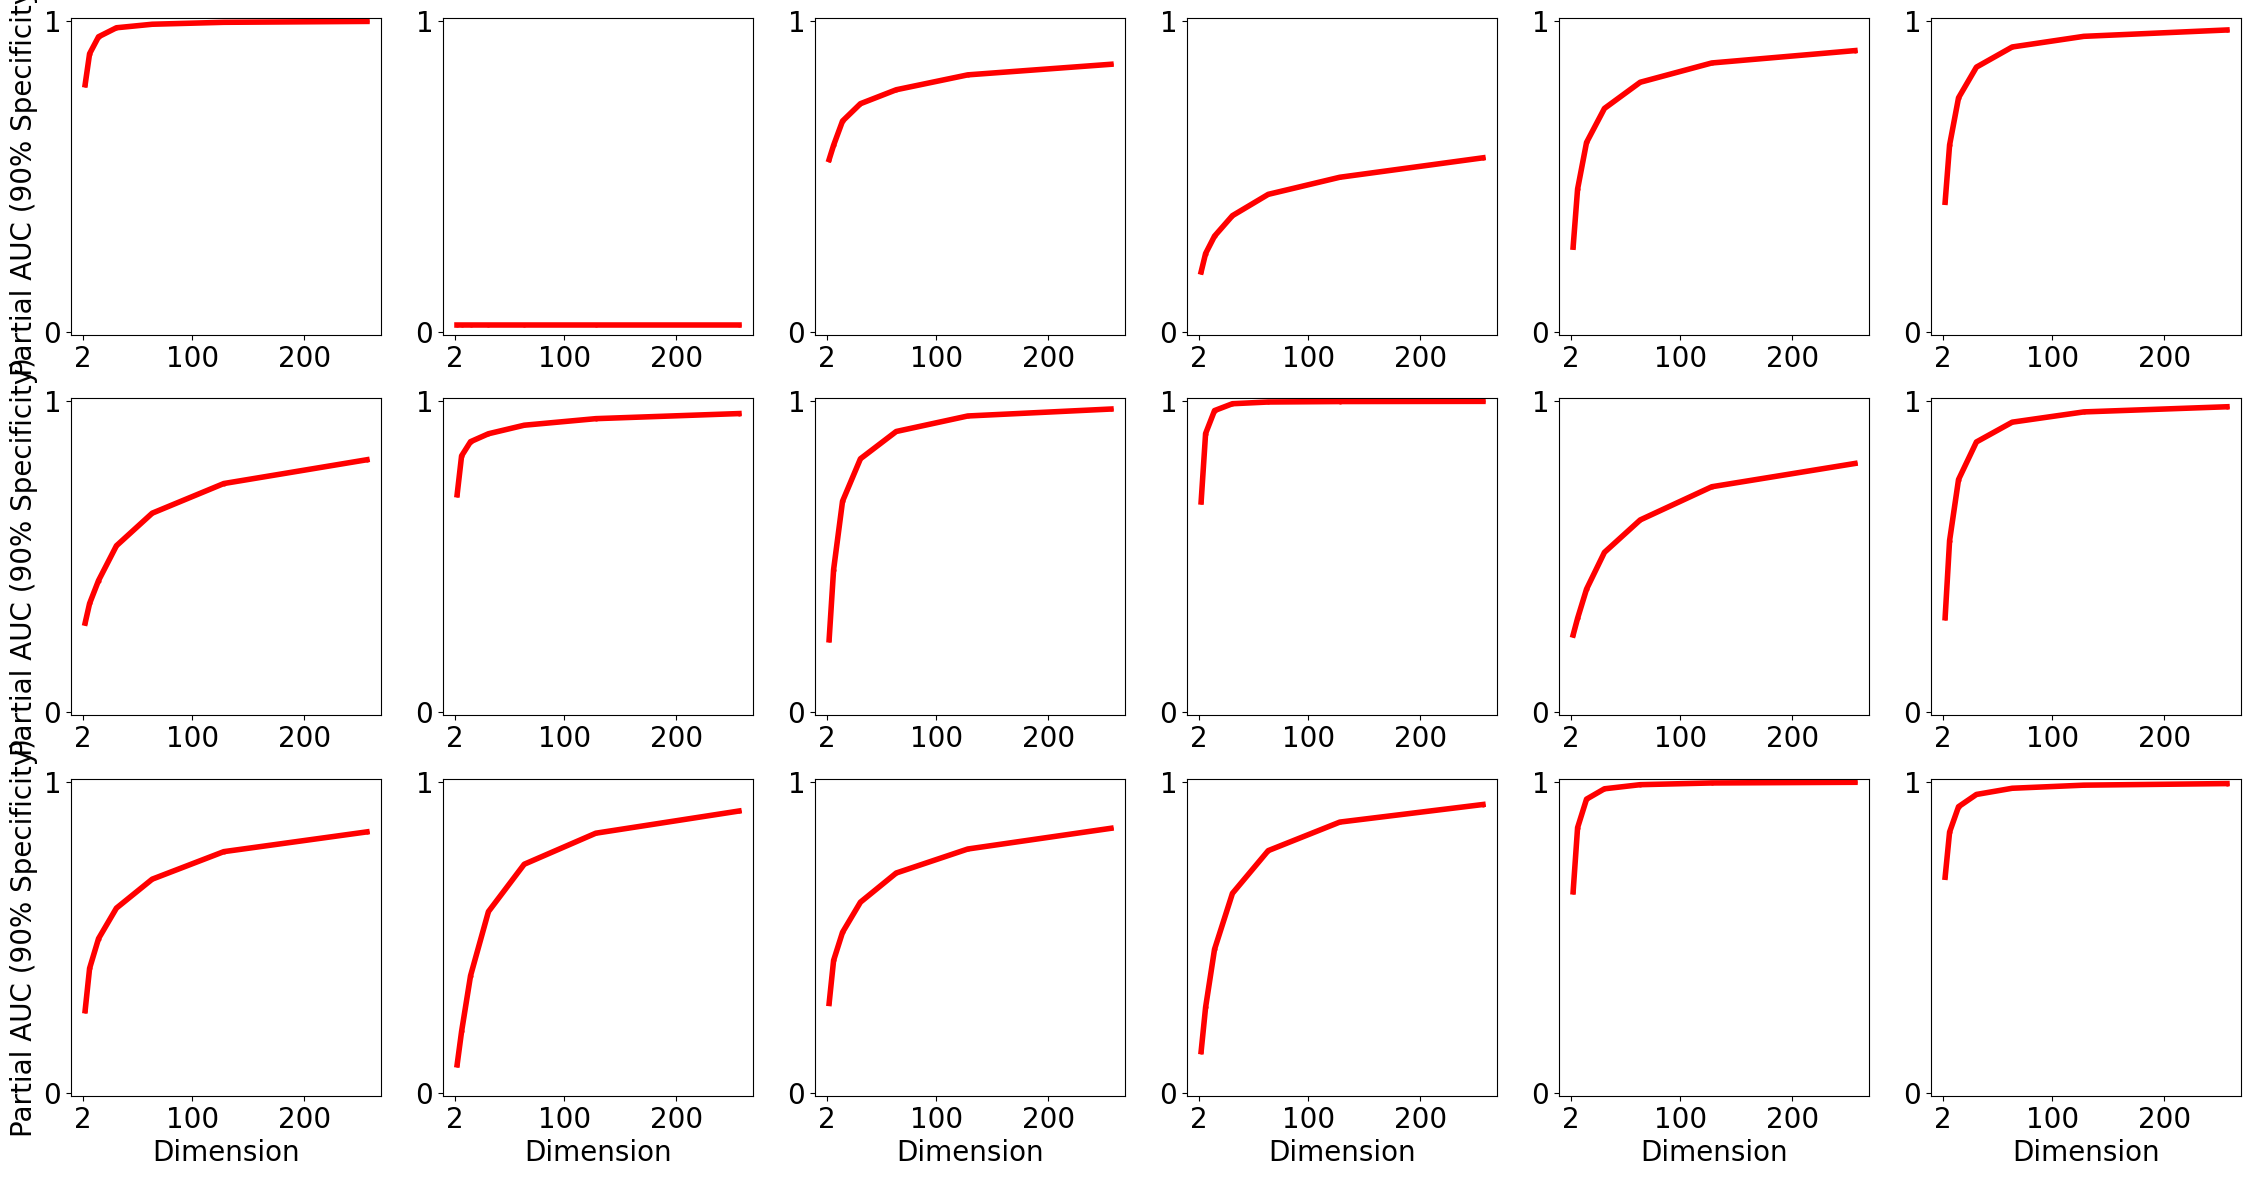

In [48]:
NROWS, NCOLS = 3, 6
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(28, 14))
# plt.axis ('off')
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = NCOLS * i + j
        sim = sim_name[count]
        truth = np.genfromtxt('/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/{}.csv'.format(sim),delimiter=',')
        col.plot(DIMENSIONS,truth, 'r',marker='o', markersize=2,label = 'Truth',linewidth =4)
        if j ==0:
            col.set_ylabel('Partial AUC (90% Specificity)')
        if i == 2:
            col.set_xlabel('Dimension')
        col.set_title(SIMULATIONS[sim])
        col.set_ylim((-0.01,1.01))
        col.set_yticks((0,1))
        col.set_xticks((2,100,200))
                